# Training Different Versions of the model

### V1 Contains: 
- Prioritized Memory Replay wich contains
    - sampling priority scale
    - importance weight beta
- Both Actor and Critic uses the same feature layer


### V2 Contains: 
- Option to select Residual Blocks are added
- Option to Delay the Critic by a certain frequency --> the fixed critic is used to generate episodes for the model to train on. 
- Option to use a Double Q network, where both Q networks are used to make a value prediction and the minimum of their value prediction is used. 
- Option to use an actor and critic model where they don't share any parameters

### V3 Contains: 
- Random State Initialization
- Option to use PPO for updating the Actor

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import torch.distributions as distributions

plt.style.use("tableau-colorblind10")
plt.rcParams.update({'font.size': 14})


In [3]:
# Import resources for the game env 
from engines.environment import HexChessEnv
from hexchess.players import RandomPlayer, GreedyPlayer
from engines.train_a2c import A2C, A2CLearning
from utils import plot_step_rewards, plot_episode_rewards

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
# Constants
base_path = os.path.join("assets", "a2c")
figs_path = os.path.join("figures", "a2c")
print(base_path, figs_path)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

assets/a2c figures/a2c
mps


In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Simple A2C vs Random

In [7]:

'''
Model Being Trained: A2C Model with Prioritized Memory Replay without Residual Block vs Random Player
Both Actor and Critic share the same feature extraction layers!
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = None
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/simple_a2c_random.pth"


# Environment parameters
opponent_class = RandomPlayer
opponent_is_white = True
apply_negative_scores = False

# A2C Learning parameters
n_episodes = 1000
max_steps = 150
gamma = 0.4
learning_rate = 1e-3

# A2C Model parameters
residual_blocks = False

# Prioritized Memory Replay parameters
memory_size = 2048
sampling_priority_scale = 0.7
replace_sample = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.38

################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, residual_blocks=residual_blocks)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks)
model.to(device)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, env=env, memory_size=memory_size, device=device)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
rewards, losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start) 

#Save Model
learning_system.save(model_save_path)

Device:  mps
Number of trainable parameters in the A2C model: 24406026
Episodes 0-9: Average Reward: 40.70, Total Episode Reward: 407.00,Average Losses: 3.3352 -> Policy: -0.7762, Value: 4.1114 


KeyboardInterrupt: 

In [32]:
v1_1_rewards, v1_1_losses = rewards, losses

In [139]:
# Save results
model_name = "a2c_ps_random_conv_v1_1"
losses_df = pd.DataFrame(v1_1_losses)
np.savetxt(os.path.join(base_path, f"{model_name}_rewards.csv"), v1_1_rewards, delimiter=",")
losses_df.to_csv(os.path.join(base_path, f"{model_name}_losses.csv"), index=False)

In [165]:
# Load Results
model_name = "a2c_ps_random_conv_v1_1"
csv_losses_path = os.path.join(base_path, f"{model_name}_losses.csv")
csv_rewards_path = os.path.join(base_path, f"{model_name}_rewards.csv")
losses_df = pd.read_csv(csv_losses_path)
rewards = np.loadtxt(csv_rewards_path, delimiter=",")

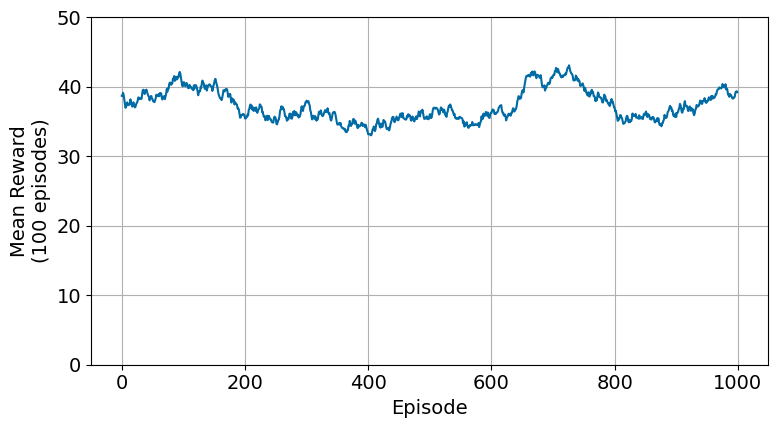

In [47]:
# Make plots
model_name = "simple_a2c_random"
kernel_size = 100
fig, ax = plot_episode_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

## Simple A2C vs Greedy

In [54]:

'''
Model Being Trained: A2C Model with Prioritized Memory Replay without Residual Block vs Greedy Player
Both Actor and Critic share the same feature extraction layers!
Initialize the model with weights learned by playing against RandomPlayer. 
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/simple_a2c_random.pth"
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/simple_a2c_greedy.pth"


# Environment parameters
opponent_class = GreedyPlayer
opponent_is_white = True
apply_negative_scores = False

# A2C Learning parameters
n_episodes = 5000
max_steps = 150
gamma = 0.6
learning_rate = 1e-3

# A2C Model parameters
residual_blocks = False

# Prioritized Memory Replay parameters
memory_size = 2048
sampling_priority_scale = 0.7
replace_sample = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.38

################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, residual_blocks=residual_blocks)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks)
model.to(device)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, env=env, memory_size=memory_size, device=device)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
rewards, losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start) 

#Save Model
learning_system.save(model_save_path)

Device:  mps
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/simple_a2c_random.pth
Number of trainable parameters in the A2C model: 24406026
Episodes 0-9: Average Reward: 1.20, Total Episode Reward: 12.00,Average Losses: -61.7410 -> Policy: -61.9341, Value: 0.1931 
Episodes 10-19: Average Reward: 2.30, Total Episode Reward: 23.00,Average Losses: -122.3583 -> Policy: -122.5676, Value: 0.2093 
Episodes 20-29: Average Reward: 2.10, Total Episode Reward: 21.00,Average Losses: -113.4483 -> Policy: -113.7260, Value: 0.2777 
Episodes 30-39: Average Reward: 0.90, Total Episode Reward: 9.00,Average Losses: -154.6480 -> Policy: -154.9396, Value: 0.2917 
Episodes 40-49: Average Reward: 2.50, Total Episode Reward: 25.00,Average Losses: -174.7529 -> Policy: -175.0765, Value: 0.3236 
Episodes 50-59: Average Reward: 1.00, Total Episode Reward: 10.00,Average Losses: -234.5607 -> Policy: -234.9249, Value: 0.3642 
Epi

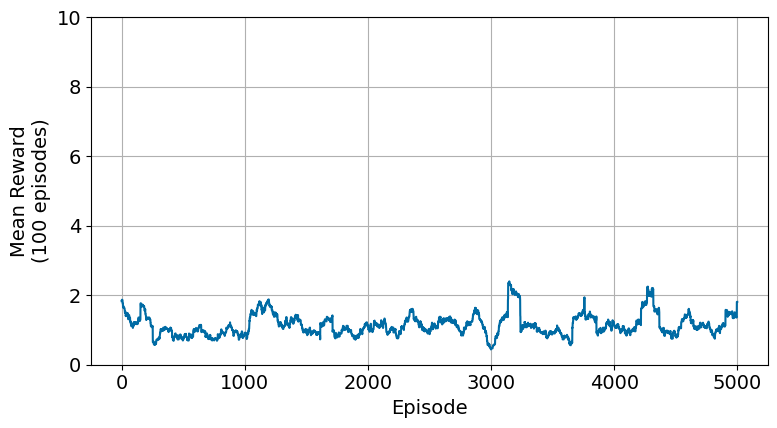

In [55]:
# Make plots
model_name = "simple_a2c_greedy"
kernel_size = 100
fig, ax = plot_episode_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

## Advanced A2C vs Random

In [8]:

'''
Model Being Trained: A2C Model with Prioritized Memory Replay without Residual Block vs Greedy Player
Both Actor and Critic share the same feature extraction layers!
Initialize the model with weights learned by playing against RandomPlayer. 
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = None
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_a2c_random.pth"


# Environment parameters
opponent_class = RandomPlayer
opponent_is_white = True
apply_negative_scores = False
board_kwargs = {
    "initialize_random": True,
    "save_dir": os.path.join("a2c_states", f"{np.random.randint(1000, 10000)}".zfill(5)),
}

# A2C Learning parameters
n_episodes = 1000
max_steps = 150
gamma = 0.4
learning_rate = 1e-3

# A2C Model parameters
residual_blocks = True
shared_feature_extraction = False
delayed_critic = True
critic_delay_freq = 5
double_critic = True
use_PPO = True 
clip_epsilon = 0.2

# Prioritized Memory Replay parameters
memory_size = 2048
sampling_priority_scale = 0.7
replace_sample = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.38

################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores, board_kwargs=board_kwargs)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, 
                residual_blocks=residual_blocks, shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic, PPO=use_PPO)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks,
                shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic, PPO=use_PPO)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, 
                              env=env, 
                              memory_size=memory_size, device=device, 
                              double_critic=double_critic, PPO = use_PPO)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
rewards, losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start, 
                                         clip_epsilon=clip_epsilon) 

#Save Model
learning_system.save(model_save_path)

Device:  mps
Number of trainable parameters in the A2C model: 48898445
Episodes 0-9: Average Reward: 31.80, Total Episode Reward: 318.00,Average Losses: 10.1840 -> Policy: 0.2716, Value: 9.9124 
Episodes 10-19: Average Reward: 15.10, Total Episode Reward: 151.00,Average Losses: 9.5601 -> Policy: 0.1372, Value: 9.4229 
Episodes 20-29: Average Reward: 30.20, Total Episode Reward: 302.00,Average Losses: 12.5557 -> Policy: 0.0859, Value: 12.4697 
Episodes 30-39: Average Reward: 35.30, Total Episode Reward: 353.00,Average Losses: 13.7463 -> Policy: 0.0633, Value: 13.6830 
Episodes 40-49: Average Reward: 29.80, Total Episode Reward: 298.00,Average Losses: 17.1166 -> Policy: 0.0699, Value: 17.0468 
Episodes 50-59: Average Reward: 30.00, Total Episode Reward: 300.00,Average Losses: 19.2470 -> Policy: 0.1097, Value: 19.1373 
Episodes 60-69: Average Reward: 11.00, Total Episode Reward: 110.00,Average Losses: 15.6050 -> Policy: 0.1397, Value: 15.4653 
Episodes 70-79: Average Reward: 32.10, Total 

KeyboardInterrupt: 

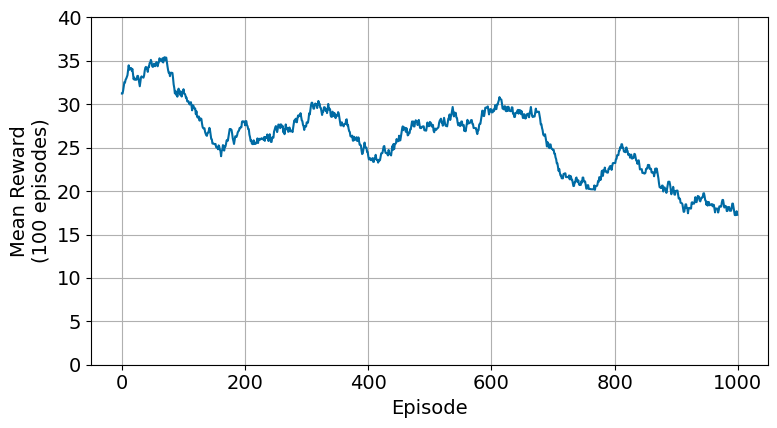

In [7]:
# Make plots
model_name = "advanced_a2c_random"
kernel_size = 100
fig, ax = plot_episode_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

## Advanced A2C vs Greedy

In [7]:

'''
Model Being Trained: A2C Model with Prioritized Memory Replay without Residual Block vs Greedy Player
Both Actor and Critic share the same feature extraction layers!
Initialize the model with weights learned by playing against RandomPlayer. 
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_a2c_random.pth"
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_a2c_greedy.pth"


# Environment parameters
opponent_class = GreedyPlayer
opponent_is_white = True
apply_negative_scores = False
board_kwargs = {
    "initialize_random": True,
    "save_dir": os.path.join("a2c_states", f"{np.random.randint(1000, 10000)}".zfill(5)),
}

# A2C Learning parameters
n_episodes = 5000
max_steps = 150
gamma = 0.4
learning_rate = 1e-3

# A2C Model parameters
residual_blocks = True
shared_feature_extraction = False
delayed_critic = True
critic_delay_freq = 5
double_critic = True
use_PPO = True 
clip_epsilon = 0.2

# Prioritized Memory Replay parameters
memory_size = 2048
sampling_priority_scale = 0.7
replace_sample = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.38

################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores, board_kwargs=board_kwargs)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, 
                residual_blocks=residual_blocks, shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic, PPO=use_PPO)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks,
                shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic, PPO=use_PPO)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, 
                              env=env, 
                              memory_size=memory_size, device=device, 
                              double_critic=double_critic, PPO = use_PPO)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
rewards, losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start, 
                                         clip_epsilon=clip_epsilon) 

#Save Model
learning_system.save(model_save_path)

Device:  mps
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_a2c_random.pth
Number of trainable parameters in the A2C model: 48898445
Episodes 0-9: Average Reward: 0.90, Total Episode Reward: 9.00,Average Losses: 0.7286 -> Policy: 0.2581, Value: 0.4705 
Episodes 10-19: Average Reward: 0.30, Total Episode Reward: 3.00,Average Losses: 0.1999 -> Policy: 0.0894, Value: 0.1105 
Episodes 20-29: Average Reward: 1.20, Total Episode Reward: 12.00,Average Losses: 0.3037 -> Policy: 0.0290, Value: 0.2746 
Episodes 30-39: Average Reward: 1.00, Total Episode Reward: 10.00,Average Losses: 0.3560 -> Policy: 0.0323, Value: 0.3237 
Episodes 40-49: Average Reward: 0.20, Total Episode Reward: 2.00,Average Losses: 0.2108 -> Policy: 0.0226, Value: 0.1882 
Episodes 50-59: Average Reward: 0.30, Total Episode Reward: 3.00,Average Losses: 0.1884 -> Policy: 0.0258, Value: 0.1626 
Episodes 60-69: Average Reward: 0.10, 

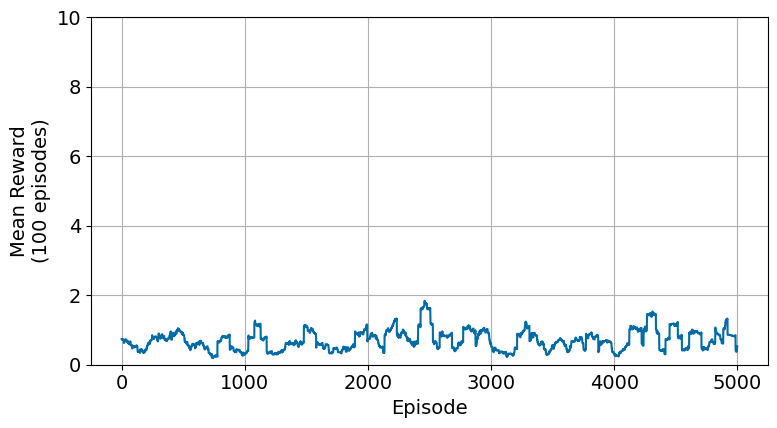

In [8]:
# Make plots
model_name = "advanced_a2c_greedy"
kernel_size = 100
fig, ax = plot_episode_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

## Playground

In [16]:

'''
V2_1:

Model Being Trained: A2C Model with 
- Opponent: Random Player
- Prioritized Memory Replay
- Residual Blocks 
- Delayed Critic 
- Seperate Actor and Critic Models
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = None
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/assets/a2c/a2c_ps_random_residual_v2_1.pth"


# Environment parameters
opponent_class = RandomPlayer
opponent_is_white = True
apply_negative_scores = False

# A2C Learning parameters
n_episodes = 800
max_steps = 120
gamma = 0.18
learning_rate = 1e-4

# A2C Model parameters
residual_blocks = True
shared_feature_extraction = False
delayed_critic = True
critic_delay_freq = 5
double_critic = False

# Prioritized Memory Replay parameters
memory_size = 9600
sampling_priority_scale = 0.72
replace_sample = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.35 


################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, 
                residual_blocks=residual_blocks, shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks,
                shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, env=env, memory_size=memory_size, device=device, double_critic=double_critic)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
v2_1_rewards, v2_1_losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start) 

#Save Model
learning_system.save(model_save_path)

Device:  mps
Number of trainable parameters in the A2C model: 32733867
Episodes 0-9: Average Reward: 17.40, Total Episode Reward: 174.00,Average Losses: 9.6675 -> Policy: 0.8711, Value: 8.7963 
Episodes 10-19: Average Reward: 42.30, Total Episode Reward: 423.00,Average Losses: 25.5320 -> Policy: 4.9161, Value: 20.6159 
Episodes 20-29: Average Reward: 22.40, Total Episode Reward: 224.00,Average Losses: 13.4073 -> Policy: -1.1730, Value: 14.5802 
Episodes 30-39: Average Reward: 28.70, Total Episode Reward: 287.00,Average Losses: 13.6740 -> Policy: 0.9737, Value: 12.7003 
Episodes 40-49: Average Reward: 14.20, Total Episode Reward: 142.00,Average Losses: 0.3276 -> Policy: -2.5937, Value: 2.9213 
Episodes 50-59: Average Reward: 22.30, Total Episode Reward: 223.00,Average Losses: 13.8288 -> Policy: -0.2475, Value: 14.0763 
Episodes 60-69: Average Reward: 16.30, Total Episode Reward: 163.00,Average Losses: 0.7581 -> Policy: -2.3318, Value: 3.0899 
Episodes 70-79: Average Reward: 52.50, Total

In [18]:
len(v2_1_rewards), len(v2_1_losses)

(800, 3)

In [19]:
# Save results
model_name = "a2c_ps_random_residual_v2_1"
losses_df = pd.DataFrame(v2_1_losses)
np.savetxt(os.path.join(base_path, f"{model_name}_rewards.csv"), v2_1_rewards, delimiter=",")
losses_df.to_csv(os.path.join(base_path, f"{model_name}_losses.csv"), index=False)

In [20]:
# Load Results
model_name = "a2c_ps_random_residual_v2_1"
csv_losses_path = os.path.join(base_path, f"{model_name}_losses.csv")
csv_rewards_path = os.path.join(base_path, f"{model_name}_rewards.csv")
losses_df = pd.read_csv(csv_losses_path)
rewards = np.loadtxt(csv_rewards_path, delimiter=",")

In [21]:
len(rewards), len(losses_df)

(800, 800)

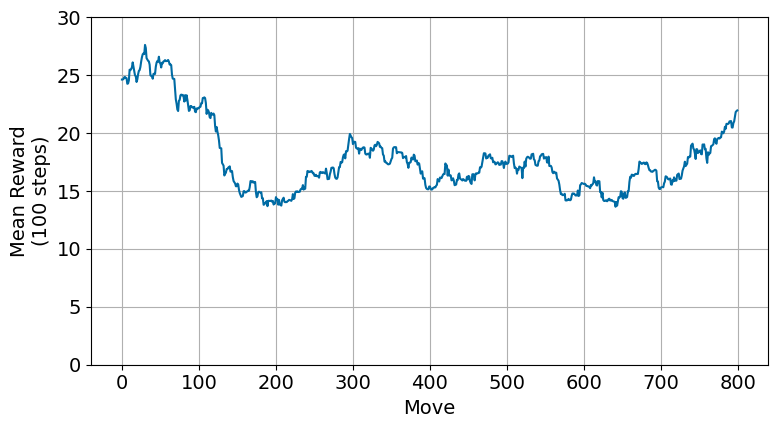

In [22]:
# Make plots
model_name = 'a2c_ps_random_residual_v2_1'
kernel_size = 100
fig, ax = plot_step_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

### V2_2

In [ ]:

'''
V2_2:

Model Being Trained: A2C Model with 
- Opponent: Random Player
- Prioritized Memory Replay
- Residual Blocks 
- Delayed Critic 
- Seperate Actor and Critic Models
- Double Q Network
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = None
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/assets/a2c/a2c_ps_random_residual_v2_2.pth"


# Environment parameters
opponent_class = RandomPlayer
opponent_is_white = True
apply_negative_scores = False

# A2C Learning parameters
n_episodes = 800
max_steps = 120
gamma = 0.18
learning_rate = 1e-4

# A2C Model parameters
residual_blocks = True
shared_feature_extraction = False
delayed_critic = True
critic_delay_freq = 5
double_critic = True

# Prioritized Memory Replay parameters
memory_size = 9600
sampling_priority_scale = 0.72
replace_sample = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.35 


################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, 
                residual_blocks=residual_blocks, shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks,
                shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, env=env, memory_size=memory_size, device=device, double_critic=double_critic)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
v2_2_rewards, v2_2_losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start) 

#Save Model
learning_system.save(model_save_path)

Device:  mps
Number of trainable parameters in the A2C model: 48898445


/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/a2c.py:928: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  td_targets = rewards + (gamma * next_values * (1 - torch.tensor(dones, dtype=torch.float32).to(self.device)))
/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/a2c.py:545: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/a2c.py:549: UserWarning: To copy construct from a tensor

Episodes 0-9: Average Reward: 15.00, Total Episode Reward: 150.00,Average Losses: 16.2319 -> Policy: 7.2493, Value: 8.9826 
Episodes 10-19: Average Reward: 28.70, Total Episode Reward: 287.00,Average Losses: 28.5348 -> Policy: 5.9855, Value: 22.5493 
Episodes 20-29: Average Reward: 27.10, Total Episode Reward: 271.00,Average Losses: 23.2325 -> Policy: 5.4654, Value: 17.7671 
Episodes 30-39: Average Reward: 29.80, Total Episode Reward: 298.00,Average Losses: 20.3390 -> Policy: 4.6449, Value: 15.6941 
Episodes 40-49: Average Reward: 43.30, Total Episode Reward: 433.00,Average Losses: 65.8931 -> Policy: 5.6990, Value: 60.1941 
Episodes 50-59: Average Reward: 37.00, Total Episode Reward: 370.00,Average Losses: 32.3497 -> Policy: 1.4508, Value: 30.8990 
Episodes 60-69: Average Reward: 17.00, Total Episode Reward: 170.00,Average Losses: 2.7726 -> Policy: -4.4304, Value: 7.2030 
Episodes 70-79: Average Reward: 20.30, Total Episode Reward: 203.00,Average Losses: 12.3715 -> Policy: -3.0938, Val

In [ ]:
len(v2_2_rewards), len(v2_2_losses)

(800, 3)

In [ ]:
# Save results
model_name = "a2c_ps_random_residual_v2_2"
losses_df = pd.DataFrame(v2_2_losses)
np.savetxt(os.path.join(base_path, f"{model_name}_rewards.csv"), v2_2_rewards, delimiter=",")
losses_df.to_csv(os.path.join(base_path, f"{model_name}_losses.csv"), index=False)

In [ ]:
# Load Results
model_name = "a2c_ps_random_residual_v2_2"
csv_losses_path = os.path.join(base_path, f"{model_name}_losses.csv")
csv_rewards_path = os.path.join(base_path, f"{model_name}_rewards.csv")
losses_df = pd.read_csv(csv_losses_path)
rewards = np.loadtxt(csv_rewards_path, delimiter=",")

In [ ]:
len(rewards), len(losses_df)

(800, 800)

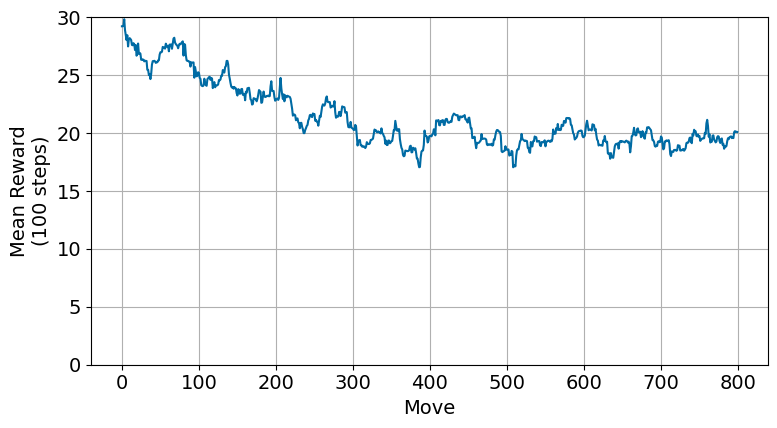

In [ ]:
# Make plots
model_name = 'a2c_ps_random_residual_v2_2'
kernel_size = 100
fig, ax = plot_step_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

### V2_3

In [32]:

'''
V2_3:

Model Being Trained: A2C Model with 
- Opponent: Random Player
- Prioritized Memory Replay
- Convolutional Blocks 
- Delayed Critic 
- Seperate Actor and Critic Models
- Double Q Network
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = None
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/assets/a2c/a2c_ps_random_conv_v2_3.pth"


# Environment parameters
opponent_class = RandomPlayer
opponent_is_white = True
apply_negative_scores = False

# A2C Learning parameters
n_episodes = 800
max_steps = 120
gamma = 0.18
learning_rate = 1e-4

# A2C Model parameters
residual_blocks = False
shared_feature_extraction = False
delayed_critic = True
critic_delay_freq = 5
double_critic = True

# Prioritized Memory Replay parameters
memory_size = 9600
sampling_priority_scale = 0.72
replace_sample = True
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.36 


################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, 
                residual_blocks=residual_blocks, shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks,
                shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, env=env, memory_size=memory_size, device=device, double_critic=double_critic)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
v2_3_rewards, v2_3_losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start) 

#Save Model
learning_system.save(model_save_path)

Device:  mps
Number of trainable parameters in the A2C model: 48412365


/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/a2c.py:925: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  td_targets = rewards + (gamma * next_values * (1 - torch.tensor(dones, dtype=torch.float32).to(self.device)))
/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/a2c.py:542: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/a2c.py:546: UserWarning: To copy construct from a tensor

Episodes 0-9: Average Reward: 51.90, Total Episode Reward: 519.00,Average Losses: 97.1766 -> Policy: 12.8053, Value: 84.3713 
Episodes 10-19: Average Reward: 40.60, Total Episode Reward: 406.00,Average Losses: 45.8106 -> Policy: 4.3813, Value: 41.4292 
Episodes 20-29: Average Reward: 11.40, Total Episode Reward: 114.00,Average Losses: -6.2557 -> Policy: -10.7037, Value: 4.4480 
Episodes 30-39: Average Reward: 27.30, Total Episode Reward: 273.00,Average Losses: 13.5140 -> Policy: -2.8855, Value: 16.3995 
Episodes 40-49: Average Reward: 23.00, Total Episode Reward: 230.00,Average Losses: 28.4910 -> Policy: -0.3317, Value: 28.8227 
Episodes 50-59: Average Reward: 14.80, Total Episode Reward: 148.00,Average Losses: 11.5643 -> Policy: -1.6636, Value: 13.2279 
Episodes 60-69: Average Reward: 25.00, Total Episode Reward: 250.00,Average Losses: 16.2121 -> Policy: -1.0477, Value: 17.2598 
Episodes 70-79: Average Reward: 30.00, Total Episode Reward: 300.00,Average Losses: 14.2372 -> Policy: 0.21

In [33]:
len(v2_3_rewards), len(v2_3_losses)

(800, 3)

In [34]:
# Save results
model_name = "a2c_ps_random_conv_v2_3"
losses_df = pd.DataFrame(v2_3_losses)
np.savetxt(os.path.join(base_path, f"{model_name}_rewards.csv"), v2_3_rewards, delimiter=",")
losses_df.to_csv(os.path.join(base_path, f"{model_name}_losses.csv"), index=False)

In [35]:
# Load Results
model_name = "a2c_ps_random_conv_v2_3"
csv_losses_path = os.path.join(base_path, f"{model_name}_losses.csv")
csv_rewards_path = os.path.join(base_path, f"{model_name}_rewards.csv")
losses_df = pd.read_csv(csv_losses_path)
rewards = np.loadtxt(csv_rewards_path, delimiter=",")

In [36]:
len(rewards), len(losses_df)

(800, 800)

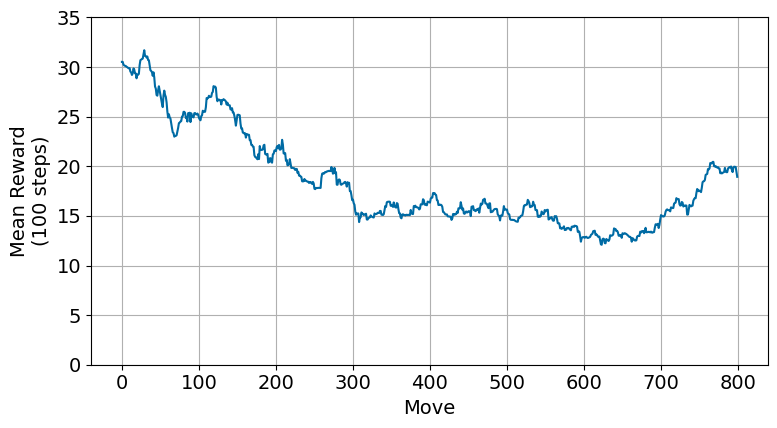

In [37]:
# Make plots
model_name = 'a2c_ps_random_conv_v2_3'
kernel_size = 100
fig, ax = plot_step_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

## V3

In [19]:

'''
V3_1:

Model Being Trained: A2C Model with 
- Opponent: Random Player
- Prioritized Memory Replay
- Residual Blocks 
- Delayed Critic
- Double Q Network
- Seperate Actor and Critic Models
- Board is Initialized to Random State at each Episode
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = None
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/assets/a2c/a2c_ps_random_residual_v3_1.pth"


# Environment parameters
opponent_class = RandomPlayer
opponent_is_white = True
apply_negative_scores = False
board_kwargs = {
    "initialize_random": True,
    "save_dir": os.path.join("a2c_states", f"{np.random.randint(1000, 10000)}".zfill(5)),
}

# A2C Learning parameters
n_episodes = 800
max_steps = 120
gamma = 0.8             # Increased Gamma to see if it helps the model learn faster
learning_rate = 1e-4

# A2C Model parameters
residual_blocks = True
shared_feature_extraction = False
delayed_critic = True
critic_delay_freq = 10
double_critic = True

# Prioritized Memory Replay parameters
memory_size = 9600
sampling_priority_scale = 0.7
replace_sample = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.36 


################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores, board_kwargs=board_kwargs)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, 
                residual_blocks=residual_blocks, shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks,
                shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, env=env, memory_size=memory_size, device=device, double_critic=double_critic)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
v3_1_rewards, v3_1_losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start) 

#Save Model
learning_system.save(model_save_path)

Device:  mps
Number of trainable parameters in the A2C model: 48898445
Episodes 0-9: Average Reward: 31.00, Total Episode Reward: 310.00,Average Losses: 49.5477 -> Policy: -0.2652, Value: 49.8129 


KeyboardInterrupt: 

In [43]:
len(v3_1_rewards), len(v3_1_losses)

(800, 3)

In [44]:
# Save results
model_name = "a2c_ps_random_residual_v3_1"
losses_df = pd.DataFrame(v3_1_losses)
np.savetxt(os.path.join(base_path, f"{model_name}_rewards.csv"), v3_1_rewards, delimiter=",")
losses_df.to_csv(os.path.join(base_path, f"{model_name}_losses.csv"), index=False)

In [46]:
# Load Results
model_name = "a2c_ps_random_residual_v3_1"
csv_losses_path = os.path.join(base_path, f"{model_name}_losses.csv")
csv_rewards_path = os.path.join(base_path, f"{model_name}_rewards.csv")
losses_df = pd.read_csv(csv_losses_path)
rewards = np.loadtxt(csv_rewards_path, delimiter=",")

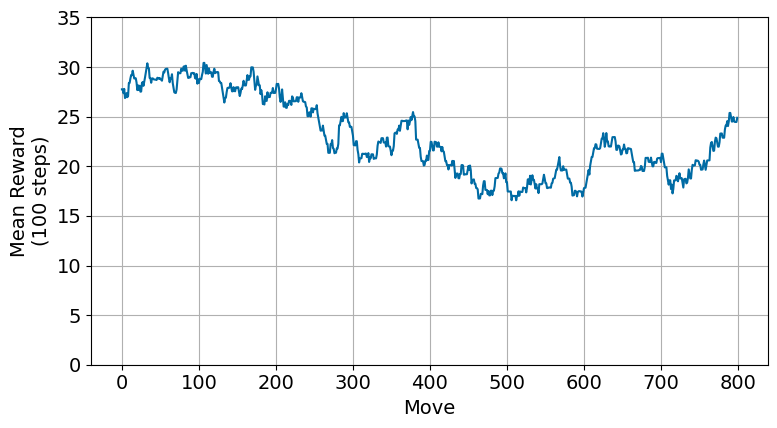

In [47]:
# Make plots
model_name = 'a2c_ps_random_residual_v3_1'
kernel_size = 100
fig, ax = plot_step_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

### V3_2

In [27]:

'''
V3_2:

Model Being Trained: A2C Model with 
- Opponent: Random Player
- Prioritized Memory Replay
- Residual Blocks 
- Shared Feature Extraction for Actor and Critic
- Board is Initialized to Random State at each Episode
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = None
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advantage_a2c_random.pth"


# Environment parameters
opponent_class = RandomPlayer
opponent_is_white = True
apply_negative_scores = False
board_kwargs = {
    "initialize_random": True,
    "save_dir": os.path.join("a2c_states", f"{np.random.randint(1000, 10000)}".zfill(5)),
}

# A2C Learning parameters
n_episodes = 1000
max_steps = 100
gamma = 0.12            # Increased Gamma to see if it helps the model learn faster
learning_rate = 1e-4

# A2C Model parameters
residual_blocks = True
shared_feature_extraction = True
delayed_critic = False
critic_delay_freq = 10
double_critic = False

# Prioritized Memory Replay parameters
memory_size = 384
sampling_priority_scale = 0.7
replace_sample = True
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.36 


################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores, board_kwargs=board_kwargs)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, 
                residual_blocks=residual_blocks, shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks,
                shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, env=env, memory_size=memory_size, device=device, double_critic=double_critic)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
v3_2_rewards, v3_2_losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start) 

#Save Model
learning_system.save(model_save_path)

SyntaxError: invalid syntax (84754129.py, line 19)

In [25]:
len(v3_2_rewards), len(v3_2_losses)

(1000, 3)

In [58]:
# Save results
model_name = "a2c_ps_random_residual_shared_v3_2"
losses_df = pd.DataFrame(v3_2_losses)
np.savetxt(os.path.join(base_path, f"{model_name}_rewards.csv"), v3_2_rewards, delimiter=",")
losses_df.to_csv(os.path.join(base_path, f"{model_name}_losses.csv"), index=False)

In [6]:
# Load Results
model_name = "a2c_ps_random_residual_shared_v3_2"
csv_losses_path = os.path.join(base_path, f"{model_name}_losses.csv")
csv_rewards_path = os.path.join(base_path, f"{model_name}_rewards.csv")
losses_df = pd.read_csv(csv_losses_path)
rewards = np.loadtxt(csv_rewards_path, delimiter=",")

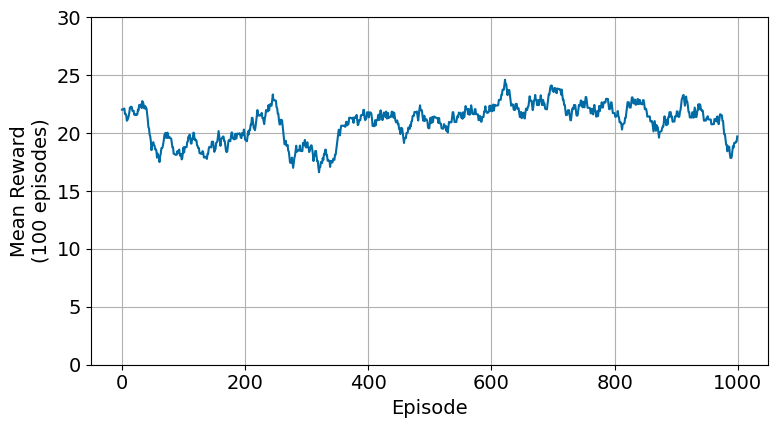

In [26]:
# Make plots
rewards = v3_2_rewards
model_name = 'result_advatnage_critic_random'
kernel_size = 100
fig, ax = plot_episode_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

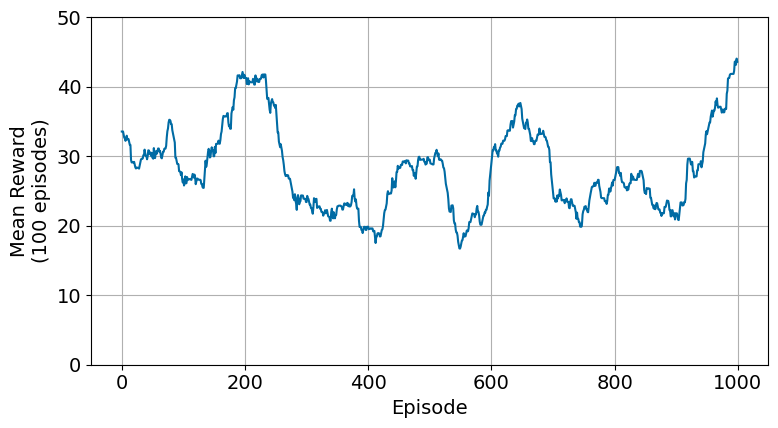

In [14]:
# Make plots
rewards = v3_2_rewards
model_name = 'result_advatnage_critic_random'
kernel_size = 100
fig, ax = plot_episode_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

In [15]:

'''
V3_2 --> Greedy Player:

Model Being Trained: A2C Model with 
- Opponent: Greedy Player
- Prioritized Memory Replay
- Residual Blocks 
- Shared Feature Extraction for Actor and Critic
- Board is Initialized to Random State at each Episode
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advantage_a2c_random.pth"
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advantage_a2c_greedy.pth"


# Environment parameters
opponent_class = GreedyPlayer
opponent_is_white = True
apply_negative_scores = False
board_kwargs = {
    "initialize_random": True,
    "save_dir": os.path.join("a2c_states", f"{np.random.randint(1000, 10000)}".zfill(5)),
}

# A2C Learning parameters
n_episodes = 5000
max_steps = 100
gamma = 0.12            # Increased Gamma to see if it helps the model learn faster
learning_rate = 1e-4

# A2C Model parameters
residual_blocks = True
shared_feature_extraction = True
delayed_critic = False
critic_delay_freq = 8
double_critic = False

# Prioritized Memory Replay parameters
memory_size = 300
sampling_priority_scale = 0.7
replace_sample = True
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.36 


################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores, board_kwargs=board_kwargs)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, 
                residual_blocks=residual_blocks, shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks,
                shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, env=env, memory_size=memory_size, device=device, double_critic=double_critic)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
v3_2_rewards, v3_2_losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start) 

#Save Model
learning_system.save(model_save_path)

Device:  mps
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advantage_a2c_random.pth
Number of trainable parameters in the A2C model: 24503242


/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/advantage_a2c.py:1169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (1 - torch.tensor(dones, dtype=torch.float32).to(self.device))
/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/advantage_a2c.py:578: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/advantage_a2c.py:582: UserWarning: To copy construct from a tensor, it is recomm

Episodes 0-9: Average Reward: 14.10, Total Episode Reward: 141.00,Average Losses: 1.2970 -> Policy: -0.0748, Value: 1.3718 
Episodes 10-19: Average Reward: 11.10, Total Episode Reward: 111.00,Average Losses: -0.5682 -> Policy: -1.2266, Value: 0.6584 
Episodes 20-29: Average Reward: 10.10, Total Episode Reward: 101.00,Average Losses: -2.3736 -> Policy: -2.7773, Value: 0.4037 
Episodes 30-39: Average Reward: 12.60, Total Episode Reward: 126.00,Average Losses: -0.5821 -> Policy: -1.2020, Value: 0.6200 
Episodes 40-49: Average Reward: 22.20, Total Episode Reward: 222.00,Average Losses: -1.3384 -> Policy: -2.5587, Value: 1.2202 
Episodes 50-59: Average Reward: 27.10, Total Episode Reward: 271.00,Average Losses: -3.0153 -> Policy: -4.4093, Value: 1.3940 
Episodes 60-69: Average Reward: 32.80, Total Episode Reward: 328.00,Average Losses: -7.1615 -> Policy: -8.7293, Value: 1.5678 
Episodes 70-79: Average Reward: 28.70, Total Episode Reward: 287.00,Average Losses: -7.7146 -> Policy: -9.0711, Va

In [69]:
len(v3_2_rewards), len(v3_2_losses)

(800, 3)

In [70]:
# Save results
model_name = "a2c_ps_greedy_residual_shared_v3_2"
losses_df = pd.DataFrame(v3_2_losses)
np.savetxt(os.path.join(base_path, f"{model_name}_rewards.csv"), v3_2_rewards, delimiter=",")
losses_df.to_csv(os.path.join(base_path, f"{model_name}_losses.csv"), index=False)

In [8]:
# Load Results

model_name = "a2c_ps_greedy_residual_shared_v3_2"
csv_losses_path = os.path.join(base_path, f"{model_name}_losses.csv")
csv_rewards_path = os.path.join(base_path, f"{model_name}_rewards.csv")
losses_df = pd.read_csv(csv_losses_path)
rewards = np.loadtxt(csv_rewards_path, delimiter=",")

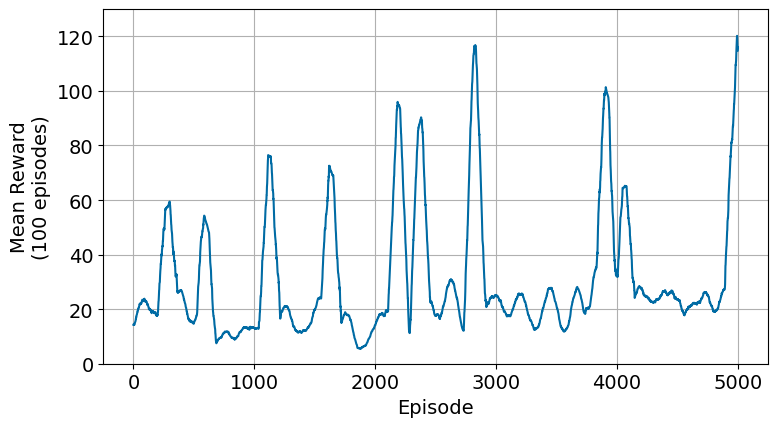

In [17]:
# Make plots
rewards = v3_2_rewards
model_name = 'a2c_ps_greedy_residual_shared_v3_2'
kernel_size = 100
fig, ax = plot_episode_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

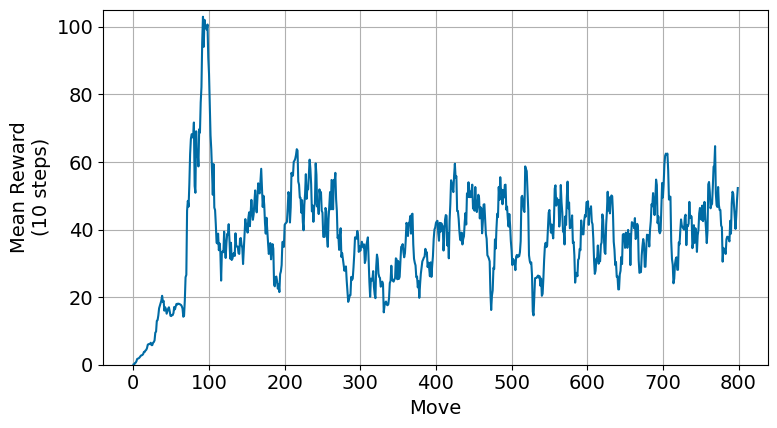

In [9]:
# Make plots
rewards = v3_2_rewards
model_name = 'a2c_ps_greedy_residual_shared_v3_2'
kernel_size = 10
fig, ax = plot_episode_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

### V3_3

In [83]:

'''
V3_3:

Model Being Trained: A2C Model with 
- Opponent: Random Player
- Prioritized Memory Replay
- Residual Blocks 
- Shared Feature Extraction for Actor and Critic
- Board is Initialized to Random State at each Episode
- PPO for Actor Loss
- Testing if normalizing advantages during update step helps
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = None
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/assets/a2c/a2c_ps_random_residual_shared_ppo_v3_3.pth"


# Environment parameters
opponent_class = RandomPlayer
opponent_is_white = True
apply_negative_scores = False
board_kwargs = {
    "initialize_random": True,
    "save_dir": os.path.join("a2c_states", f"{np.random.randint(1000, 10000)}".zfill(5)),
}

# A2C Learning parameters
n_episodes = 800
max_steps = 100
gamma = 0.12            # Increased Gamma to see if it helps the model learn faster
learning_rate = 1e-4
use_PPO = True 
clip_epsilon = 0.2

# A2C Model parameters
residual_blocks = True
shared_feature_extraction = True
delayed_critic = False
critic_delay_freq = 10
double_critic = False

# Prioritized Memory Replay parameters
memory_size = 9600
sampling_priority_scale = 0.7
replace_sample = True
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.36 


################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores, board_kwargs=board_kwargs)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, 
                residual_blocks=residual_blocks, shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic, PPO=use_PPO)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks,
                shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic, PPO=use_PPO)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, 
                              env=env, 
                              memory_size=memory_size, device=device, 
                              double_critic=double_critic, PPO = use_PPO)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
v3_2_rewards, v3_2_losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start, 
                                         clip_epsilon=clip_epsilon) 

#Save Model
learning_system.save(model_save_path)

Device:  mps
Number of trainable parameters in the A2C model: 24503242


/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/a2c.py:1021: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/a2c.py:565: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/a2c.py:569: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Episodes 0-9: Average Reward: 30.90, Total Episode Reward: 309.00,Average Losses: 16.1790 -> Policy: -0.0057, Value: 16.1847 
Episodes 10-19: Average Reward: 36.20, Total Episode Reward: 362.00,Average Losses: 16.4878 -> Policy: -0.0184, Value: 16.5062 
Episodes 20-29: Average Reward: 35.40, Total Episode Reward: 354.00,Average Losses: 14.7601 -> Policy: -0.0093, Value: 14.7694 
Episodes 30-39: Average Reward: 33.90, Total Episode Reward: 339.00,Average Losses: 10.1379 -> Policy: -0.0134, Value: 10.1513 
Episodes 40-49: Average Reward: 41.10, Total Episode Reward: 411.00,Average Losses: 13.9756 -> Policy: -0.0088, Value: 13.9843 
Episodes 50-59: Average Reward: 24.70, Total Episode Reward: 247.00,Average Losses: 6.7648 -> Policy: -0.0002, Value: 6.7651 
Episodes 60-69: Average Reward: 54.00, Total Episode Reward: 540.00,Average Losses: 22.0803 -> Policy: -0.0320, Value: 22.1123 
Episodes 70-79: Average Reward: 34.60, Total Episode Reward: 346.00,Average Losses: 9.8939 -> Policy: 0.0000

In [13]:

'''
 Model against Random:


Model Being Trained: A2C Model with 
- Opponent: Random Player
- Prioritized Memory Replay
- Residual Blocks 
- Shared Feature Extraction for Actor and Critic
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = None
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advantage_a2c_random.pth"


# Environment parameters
opponent_class = RandomPlayer
opponent_is_white = True
apply_negative_scores = False

# A2C Learning parameters
n_episodes = 1000
max_steps = 100
gamma = 0.25            # Increased Gamma to see if it helps the model learn faster
learning_rate = 1e-3

# A2C Model parameters
residual_blocks = True
shared_feature_extraction = True
delayed_critic = False
critic_delay_freq = 10
double_critic = False

# Prioritized Memory Replay parameters
memory_size = 2048
batch_size = 512
sampling_priority_scale = 0.7
replace_sample = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.36 


################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, 
                residual_blocks=residual_blocks, shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks,
                shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, env=env, memory_size=memory_size, device=device, double_critic=double_critic)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
result_rewards, result_losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start, batch_size=batch_size) 

#Save Model
learning_system.save(model_save_path)

Device:  mps
Number of trainable parameters in the A2C model: 24503242
Episodes 0-9: Average Reward: 33.50, Total Episode Reward: 335.00,Average Losses: 1.4581 -> Policy: -0.6523, Value: 2.1104 
Episodes 10-19: Average Reward: 30.20, Total Episode Reward: 302.00,Average Losses: 1.1106 -> Policy: -1.8660, Value: 2.9766 
Episodes 20-29: Average Reward: 44.40, Total Episode Reward: 444.00,Average Losses: 1.7649 -> Policy: -2.5634, Value: 4.3284 
Episodes 30-39: Average Reward: 28.50, Total Episode Reward: 285.00,Average Losses: 2.6883 -> Policy: -2.7156, Value: 5.4039 
Episodes 40-49: Average Reward: 28.10, Total Episode Reward: 281.00,Average Losses: 0.0986 -> Policy: -4.5825, Value: 4.6811 
Episodes 50-59: Average Reward: 23.30, Total Episode Reward: 233.00,Average Losses: -3.0804 -> Policy: -5.5061, Value: 2.4258 
Episodes 60-69: Average Reward: 40.10, Total Episode Reward: 401.00,Average Losses: -2.9494 -> Policy: -5.7091, Value: 2.7596 
Episodes 70-79: Average Reward: 35.20, Total Ep

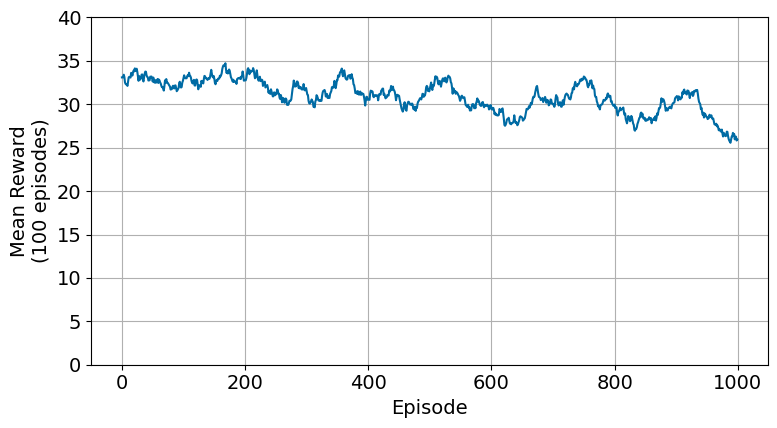

In [14]:
# Make plots
figs_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/"
rewards = result_rewards
model_name = 'result_advatnage_critic_random'
kernel_size = 100
fig, ax = plot_episode_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

In [15]:

'''
Model against Greedy:

Model Being Trained: A2C Model with 
- Opponent: Greedy Player
- Prioritized Memory Replay
- Residual Blocks 
- Shared Feature Extraction for Actor and Critic
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advantage_a2c_random.pth"
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advantage_a2c_greedy.pth"


# Environment parameters
opponent_class = GreedyPlayer
opponent_is_white = True
apply_negative_scores = False

# A2C Learning parameters
n_episodes = 5000
max_steps = 100
gamma = 0.25            # Increased Gamma to see if it helps the model learn faster
learning_rate = 1e-3

# A2C Model parameters
residual_blocks = True
shared_feature_extraction = True
delayed_critic = False
critic_delay_freq = 10
double_critic = False

# Prioritized Memory Replay parameters
memory_size = 2048
batch_size = 512
sampling_priority_scale = 0.7
replace_sample = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.36 


################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, 
                residual_blocks=residual_blocks, shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks,
                shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, env=env, memory_size=memory_size, device=device, double_critic=double_critic)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
result_rewards, result_losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start, batch_size=batch_size) 

#Save Model
learning_system.save(model_save_path)

Device:  mps
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advantage_a2c_random.pth
Number of trainable parameters in the A2C model: 24503242


/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/advantage_a2c.py:1173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (1 - torch.tensor(dones, dtype=torch.float32).to(self.device))
/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/advantage_a2c.py:577: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/advantage_a2c.py:581: UserWarning: To copy construct from a tensor, it is recomm

Episodes 0-9: Average Reward: 2.20, Total Episode Reward: 22.00,Average Losses: -174.7543 -> Policy: -175.3426, Value: 0.5883 
Episodes 10-19: Average Reward: 0.50, Total Episode Reward: 5.00,Average Losses: -171.0725 -> Policy: -171.1684, Value: 0.0959 
Episodes 20-29: Average Reward: 2.00, Total Episode Reward: 20.00,Average Losses: -291.9205 -> Policy: -291.9689, Value: 0.0484 
Episodes 30-39: Average Reward: 1.60, Total Episode Reward: 16.00,Average Losses: -336.7286 -> Policy: -336.7842, Value: 0.0556 
Episodes 40-49: Average Reward: 0.60, Total Episode Reward: 6.00,Average Losses: -339.8363 -> Policy: -339.9027, Value: 0.0665 
Episodes 50-59: Average Reward: 1.30, Total Episode Reward: 13.00,Average Losses: -352.3126 -> Policy: -352.3959, Value: 0.0833 
Episodes 60-69: Average Reward: 1.40, Total Episode Reward: 14.00,Average Losses: -378.1521 -> Policy: -378.2412, Value: 0.0891 
Episodes 70-79: Average Reward: 0.50, Total Episode Reward: 5.00,Average Losses: -383.4901 -> Policy:

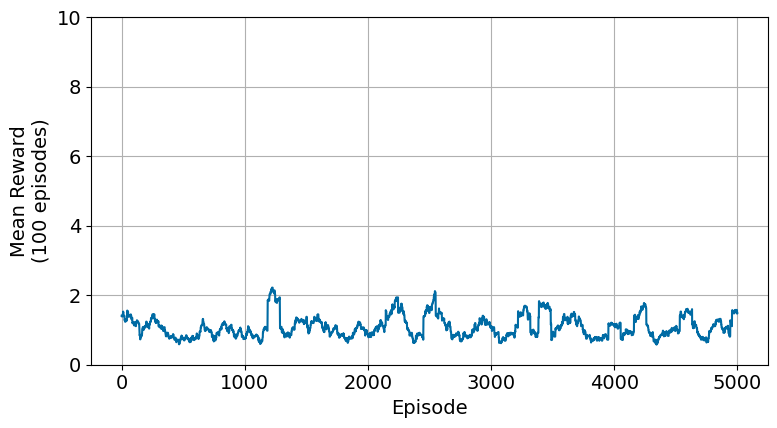

In [16]:
# Make plots
figs_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/"
rewards = result_rewards
model_name = 'result_advantage_critic_greedy'
kernel_size = 100
fig, ax = plot_episode_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

In [17]:

'''
Model against Random:


Model Being Trained: A2C Model with 
- Opponent: Random Player
- Prioritized Memory Replay
- Residual Blocks 
- Shared Feature Extraction for Actor and Critic
- PPO
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = None
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advantage_a2c_random.pth"


# Environment parameters
opponent_class = RandomPlayer
opponent_is_white = True
apply_negative_scores = False

# A2C Learning parameters
n_episodes = 1000
max_steps = 100
gamma = 0.25            # Increased Gamma to see if it helps the model learn faster
learning_rate = 1e-3
PPO = True

# A2C Model parameters
residual_blocks = True
shared_feature_extraction = True
delayed_critic = False
critic_delay_freq = 10
double_critic = False

# Prioritized Memory Replay parameters
memory_size = 2048
batch_size = 512
sampling_priority_scale = 0.7
replace_sample = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.36 


################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, 
                residual_blocks=residual_blocks, shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks,
                shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, env=env, memory_size=memory_size, device=device, double_critic=double_critic, PPO = PPO)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
result_rewards, result_losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start, batch_size=batch_size) 

#Save Model
learning_system.save(model_save_path)

Device:  mps
Number of trainable parameters in the A2C model: 24503242


/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/advantage_a2c.py:1173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (1 - torch.tensor(dones, dtype=torch.float32).to(self.device))
/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/advantage_a2c.py:577: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/advantage_a2c.py:581: UserWarning: To copy construct from a tensor, it is recomm

Episodes 0-9: Average Reward: 42.20, Total Episode Reward: 422.00,Average Losses: 1.9683 -> Policy: -0.6017, Value: 2.5700 
Episodes 10-19: Average Reward: 47.50, Total Episode Reward: 475.00,Average Losses: 2.6057 -> Policy: -1.7326, Value: 4.3384 
Episodes 20-29: Average Reward: 35.00, Total Episode Reward: 350.00,Average Losses: 3.3921 -> Policy: -3.3148, Value: 6.7069 
Episodes 30-39: Average Reward: 34.50, Total Episode Reward: 345.00,Average Losses: 4.2779 -> Policy: -5.1077, Value: 9.3857 
Episodes 40-49: Average Reward: 44.00, Total Episode Reward: 440.00,Average Losses: 1.5465 -> Policy: -5.6562, Value: 7.2027 
Episodes 50-59: Average Reward: 24.90, Total Episode Reward: 249.00,Average Losses: -1.9582 -> Policy: -6.5452, Value: 4.5870 
Episodes 60-69: Average Reward: 39.40, Total Episode Reward: 394.00,Average Losses: -4.3316 -> Policy: -6.8607, Value: 2.5291 
Episodes 70-79: Average Reward: 38.50, Total Episode Reward: 385.00,Average Losses: -5.4580 -> Policy: -8.0315, Value:

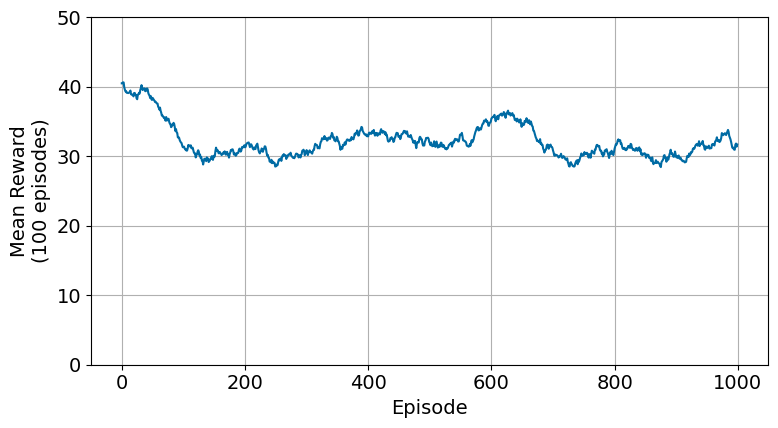

In [18]:
# Make plots
figs_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/"
rewards = result_rewards
model_name = 'result_advatnage_critic_random'
kernel_size = 100
fig, ax = plot_episode_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

In [20]:

'''
Model against Greedy:

Model Being Trained: A2C Model with 
- Opponent: Greedy Player
- Prioritized Memory Replay
- Residual Blocks 
- Shared Feature Extraction for Actor and Critic
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advantage_a2c_random.pth"
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advantage_a2c_greedy.pth"


# Environment parameters
opponent_class = GreedyPlayer
opponent_is_white = True
apply_negative_scores = False

# A2C Learning parameters
n_episodes = 5000
max_steps = 100
gamma = 0.25            # Increased Gamma to see if it helps the model learn faster
learning_rate = 1e-3

# A2C Model parameters
residual_blocks = True
shared_feature_extraction = True
delayed_critic = False
critic_delay_freq = 10
double_critic = False

# Prioritized Memory Replay parameters
memory_size = 2048
batch_size = 512
sampling_priority_scale = 0.7
replace_sample = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.36 


################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, 
                residual_blocks=residual_blocks, shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks,
                shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, env=env, memory_size=memory_size, device=device, double_critic=double_critic)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
result_rewards, result_losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start, batch_size=batch_size) 

#Save Model
learning_system.save(model_save_path)

Device:  mps
Model loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advantage_a2c_random.pth
Number of trainable parameters in the A2C model: 24503242
Episodes 0-9: Average Reward: 2.20, Total Episode Reward: 22.00,Average Losses: -107.6490 -> Policy: -108.3982, Value: 0.7491 
Episodes 10-19: Average Reward: 0.90, Total Episode Reward: 9.00,Average Losses: -204.8637 -> Policy: -205.0904, Value: 0.2267 
Episodes 20-29: Average Reward: 2.80, Total Episode Reward: 28.00,Average Losses: -179.6146 -> Policy: -179.7278, Value: 0.1132 
Episodes 30-39: Average Reward: 1.40, Total Episode Reward: 14.00,Average Losses: -155.1409 -> Policy: -155.2191, Value: 0.0782 
Episodes 40-49: Average Reward: 0.60, Total Episode Reward: 6.00,Average Losses: -165.9516 -> Policy: -166.0334, Value: 0.0817 
Episodes 50-59: Average Reward: 1.30, Total Episode Reward: 13.00,Average Losses: -174.0690 -> Policy: -174.1535, Value: 0.0845 

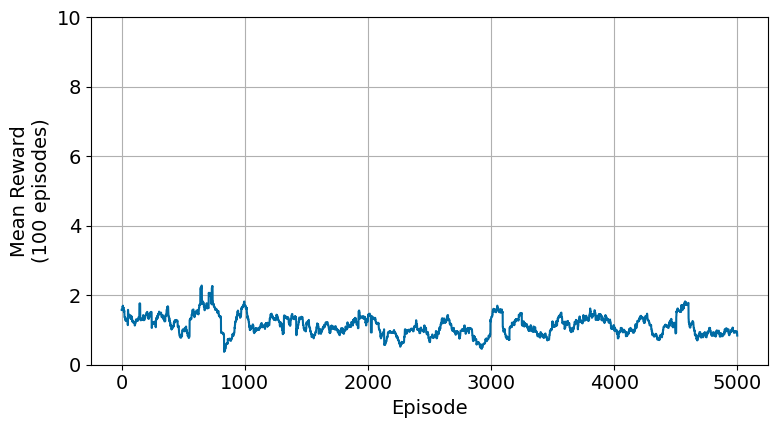

In [21]:
# Make plots
figs_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/"
rewards = result_rewards
model_name = 'result_advantage_critic_greedy'
kernel_size = 100
fig, ax = plot_episode_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

## Play Ground!

In [54]:

'''
V3_1:

Model Being Trained: A2C Model with 
- Opponent: Random Player
- Prioritized Memory Replay
- Residual Blocks 
- Delayed Critic
- Double Q Network
- Seperate Actor and Critic Models
- Board is Initialized to Random State at each Episode
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
model_load_path = None
model_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/assets/a2c/test.pth"


# Environment parameters
opponent_class = RandomPlayer
opponent_is_white = True
apply_negative_scores = False
board_kwargs = {
    "initialize_random": True,
    "save_dir": os.path.join("a2c_states", f"{np.random.randint(1000, 10000)}".zfill(5)),
}

# A2C Learning parameters
n_episodes = 100
max_steps = 100
gamma = 0.12            # Increased Gamma to see if it helps the model learn faster
learning_rate = 1e-4

# A2C Model parameters
residual_blocks = True
shared_feature_extraction = True
delayed_critic = False
critic_delay_freq = 10
double_critic = False

# Prioritized Memory Replay parameters
memory_size = 9600
sampling_priority_scale = 0.7
replace_sample = True
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = 0.36 


################
# Training
################

env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores, board_kwargs=board_kwargs)
    
# Model initialization
if model_load_path is not None:
    model = A2C(learning_rate = learning_rate, device = device, model_path=model_load_path, 
                residual_blocks=residual_blocks, shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
else: 
    model = A2C(learning_rate = learning_rate, device = device, residual_blocks=residual_blocks,
                shared_feature_extraction=shared_feature_extraction,
                delayed_critic=delayed_critic, critic_delay_freq=critic_delay_freq, 
                double_critic=double_critic)
    
# Learning system initialization
learning_system = A2CLearning(actor_critic=model, env=env, memory_size=memory_size, device=device, double_critic=double_critic)

# Convert model weights to MPS if necessary
if torch.backends.mps.is_available():
    for param in model.parameters():
        param.data = param.data.to(device='mps')

# Calculate the number of trainable parameters
    num_parameters = count_parameters(model) 
    print(f"Number of trainable parameters in the A2C model: {num_parameters}")

    
# Training
test_rewards, test_losses = learning_system.train(n_episodes=n_episodes, max_steps=max_steps, gamma=gamma, 
                                        sampling_priority_scale=sampling_priority_scale, replace_sample= replace_sample, 
                                         priority_offset=priority_offset, 
                                         update_buffer_after_forward=update_buffer_after_forward,
                                         importance_sampling_beta_start=importance_sampling_beta_start) 

#Save Model
learning_system.save(model_save_path)

Device:  mps
Number of trainable parameters in the A2C model: 24503242


/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/a2c.py:935: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  td_targets = rewards + (gamma * next_values * (1 - torch.tensor(dones, dtype=torch.float32).to(self.device)))
/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/a2c.py:542: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/engines/a2c.py:546: UserWarning: To copy construct from a tensor

Episodes 0-9: Average Reward: 47.30, Total Episode Reward: 473.00,Average Losses: 23.2455 -> Policy: 2.7866, Value: 20.4589 
Episodes 10-19: Average Reward: 109.20, Total Episode Reward: 1092.00,Average Losses: 29.1535 -> Policy: 8.2109, Value: 20.9427 
Episodes 20-29: Average Reward: 92.10, Total Episode Reward: 921.00,Average Losses: 19.7321 -> Policy: -0.1294, Value: 19.8615 
Episodes 30-39: Average Reward: 82.20, Total Episode Reward: 822.00,Average Losses: 11.0694 -> Policy: -1.3529, Value: 12.4223 
Episodes 40-49: Average Reward: 39.80, Total Episode Reward: 398.00,Average Losses: -4.0796 -> Policy: -6.2998, Value: 2.2202 
Episodes 50-59: Average Reward: 41.90, Total Episode Reward: 419.00,Average Losses: 2.9620 -> Policy: -1.2439, Value: 4.2059 
Episodes 60-69: Average Reward: 11.40, Total Episode Reward: 114.00,Average Losses: -8.4312 -> Policy: -9.5317, Value: 1.1005 
Episodes 70-79: Average Reward: 54.30, Total Episode Reward: 543.00,Average Losses: 4.8435 -> Policy: 0.7347, 